In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Read LLM prediction results from google drive

### read the LLM prediciton results

In [4]:
# read LLM results dataset
df_results = pd.read_csv('/content/gdrive/MyDrive/HU/data/unsloth/df_results_temp_06.csv')

# read LIWC
df_merged = pd.read_csv('/content/gdrive/MyDrive/HU/data/unsloth/df_merged.csv')

In [5]:
# combine LLM results and LIWC score
# df_merged_temp = df_merged.loc[:,['ID', 'LIWC_harm', 'Affect', 'tone_pos', 'tone_neg']]

merged_results = pd.merge(df_results, df_merged, on='ID', how='left', suffixes=('_results', '_LIWC'))

merged_results.shape

(308, 134)

In [6]:
# check null value
merged_results['LIWC_harm'].isnull().sum()

np.int64(0)

In [7]:
# select columns from merged results
merged_results_temp = merged_results.loc[:,['ID', 'text_results', 'label', 'pred', 'Match', 'hashtag','LIWC_harm', 'Affect', 'tone_pos', 'tone_neg']]


In [8]:
# add control variable:
merged_results_temp['text_len'] = merged_results_temp['text_results'].astype(str).str.split().str.len()

# add prediction status column
merged_results_temp['prediction_status'] = merged_results_temp['Match'].map({True: 'Match', False: 'Mismatch'})

In [9]:
# add column to do visualization
merged_results_temp["primary_hashtag"]=merged_results_temp["hashtag"]
merged_results_temp["mismatch_label"]=merged_results_temp["prediction_status"]
merged_results_temp["description_length"]=merged_results_temp["text_len"]
merged_results_temp["mismatch_binary"] = merged_results_temp["Match"].astype(int)

In [10]:
# Define a function to determine the hashtag prediction
def get_category(value):
    if value == 1:
        return "cigarette"
    elif value == 2:
        return "vaping"
    elif value == 3:
        return "tobacco"
    else:
        return "swisher"

merged_results_temp['human_hashtags'] = merged_results_temp['label'].apply(get_category)
merged_results_temp['llm_hashtags'] = merged_results_temp['pred'].apply(get_category)

In [11]:
# Rename columns
merged_results_temp = merged_results_temp.rename(columns={'text_results': 'description', 'label_temp': 'label', 'LIWC_harm':'liwc_harm', 'Affect': 'liwc_affect', 'tone_pos': 'liwc_pos', 'tone_neg': 'liwc_neg'})


In [12]:
merged_results_temp.head(3)

,ID,description,label,pred,Match,hashtag,liwc_harm,liwc_affect,liwc_pos,liwc_neg,text_len,prediction_status,primary_hashtag,mismatch_label,description_length,mismatch_binary,human_hashtags,llm_hashtags
0,65,New Movie,1,2,False,cigarette,0.0,50.00,50.00,0.0,2,Mismatch,cigarette,Mismatch,2,0,cigarette,vaping
1,1483,Swisher Sweets Commercial,4,4,True,swisher,0.0,33.33,33.33,0.0,3,Match,swisher,Match,3,1,swisher,swisher
2,1327,Hay bales and cat tails.,4,4,True,swisher,0.0,0.00,0.00,0.0,5,Match,swisher,Match,5,1,swisher,swisher


# Calculate Vader sentiment score

In [13]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [14]:
# Apply VADER sentiment analysis to the cleaned text
merged_results_temp['vader_compound'] = merged_results_temp['description'].apply(lambda x: sia.polarity_scores(x)['compound'])
merged_results_temp['vader_pos'] = merged_results_temp['description'].apply(lambda x: sia.polarity_scores(x)['pos'])
merged_results_temp['vader_neu'] = merged_results_temp['description'].apply(lambda x: sia.polarity_scores(x)['neu'])
merged_results_temp['vader_neg'] = merged_results_temp['description'].apply(lambda x: sia.polarity_scores(x)['neg'])

In [15]:
merged_results_temp.head(3)

,ID,description,label,pred,Match,hashtag,liwc_harm,liwc_affect,liwc_pos,liwc_neg,...,primary_hashtag,mismatch_label,description_length,mismatch_binary,human_hashtags,llm_hashtags,vader_compound,vader_pos,vader_neu,vader_neg
0,65,New Movie,1,2,False,cigarette,0.0,50.00,50.00,0.0,...,cigarette,Mismatch,2,0,cigarette,vaping,0.0000,0.000,1.000,0.0
1,1483,Swisher Sweets Commercial,4,4,True,swisher,0.0,33.33,33.33,0.0,...,swisher,Match,3,1,swisher,swisher,0.4939,0.615,0.385,0.0
2,1327,Hay bales and cat tails.,4,4,True,swisher,0.0,0.00,0.00,0.0,...,swisher,Match,5,1,swisher,swisher,0.0000,0.000,1.000,0.0


# Vasulization plot

# Compare LIWC Tone score, LIWC harm score, and Vader score

([0, 1, 2, 3],
 [Text(0, 0, 'cigarette'),
  Text(1, 0, 'swisher'),
  Text(2, 0, 'tobacco'),
  Text(3, 0, 'vaping')])

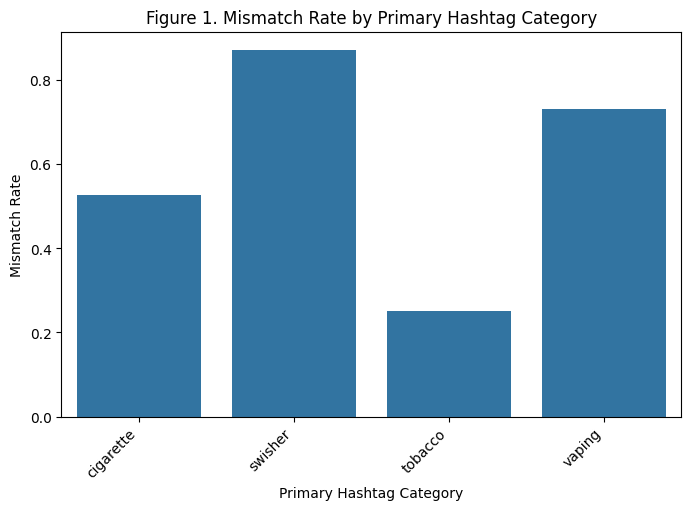

In [16]:


# Compute mismatch rate per hashtag category
hashtag_summary = (
    merged_results_temp.groupby("primary_hashtag")["mismatch_binary"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "mismatch_rate", "count": "n"})
)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=hashtag_summary,
    x="primary_hashtag",
    y="mismatch_rate",
)
plt.xlabel("Primary Hashtag Category")
plt.ylabel("Mismatch Rate")
plt.title("Figure 1. Mismatch Rate by Primary Hashtag Category")
plt.xticks(rotation=45, ha="right")

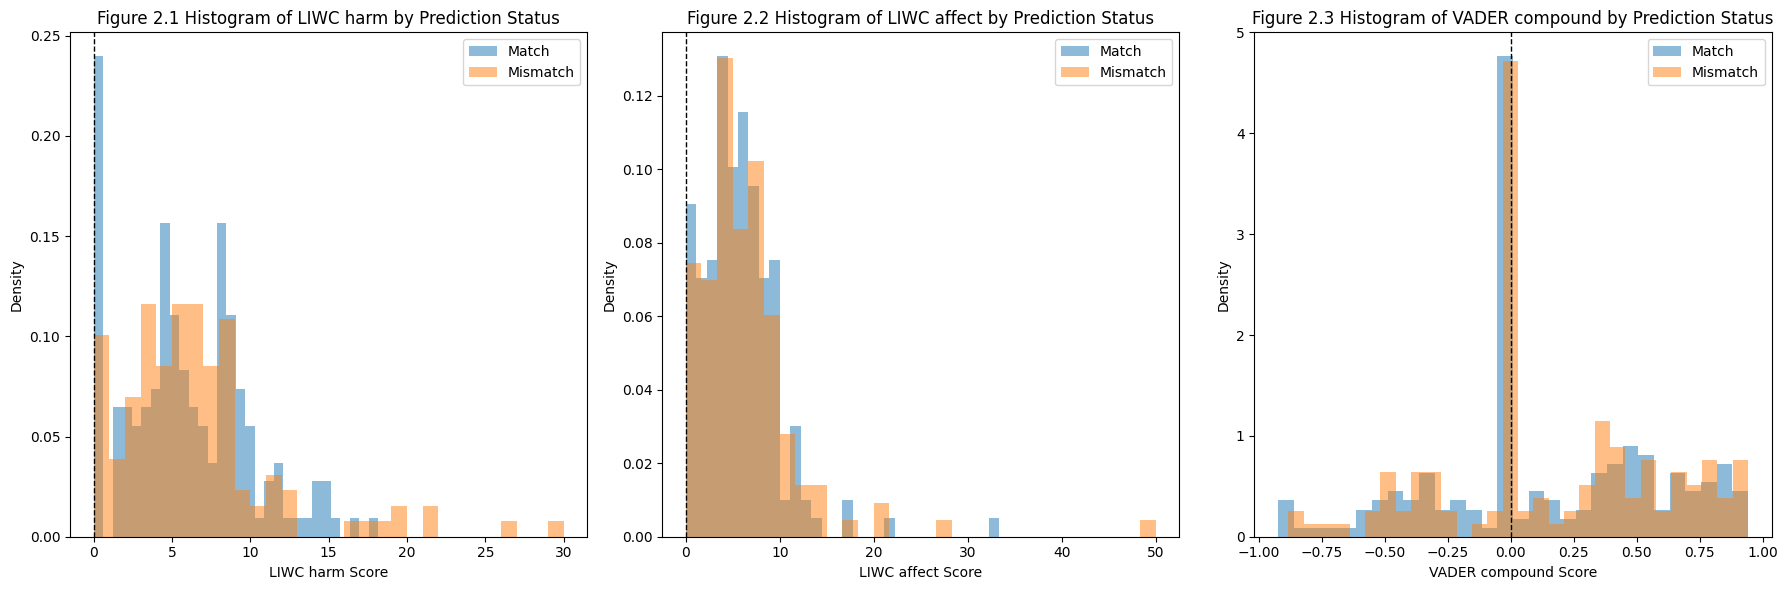

In [18]:


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
bins = 30

# Plot 1: LIWC harm by Mismatch Status
for label in ["Match", "Mismatch"]:
    subset = merged_results_temp[merged_results_temp["mismatch_label"] == label]
    ax1.hist(
        subset["liwc_harm"],
        bins=bins,
        alpha=0.5,
        label=label,
        density=True,
    )
ax1.axvline(0, color="black", linestyle="--", linewidth=1)
ax1.set_xlabel("LIWC harm Score")
ax1.set_ylabel("Density")
ax1.set_title("Figure 2.1 Histogram of LIWC harm by Prediction Status")
ax1.legend()

# Plot 2: LIWC affect by Mismatch Status
for label in ["Match", "Mismatch"]:
    subset = merged_results_temp[merged_results_temp["mismatch_label"] == label]
    ax2.hist(
        subset["liwc_affect"],
        bins=bins,
        alpha=0.5,
        label=label,
        density=True,
    )
ax2.axvline(0, color="black", linestyle="--", linewidth=1)
ax2.set_xlabel("LIWC affect Score")
ax2.set_ylabel("Density")
ax2.set_title("Figure 2.2 Histogram of LIWC affect by Prediction Status")
ax2.legend()

# Plot 3: VADER compound by Mismatch Status
for label in ["Match", "Mismatch"]:
    subset = merged_results_temp[merged_results_temp["mismatch_label"] == label]
    ax3.hist(
        subset["vader_compound"],
        bins=bins,
        alpha=0.5,
        label=label,
        density=True,
    )
ax3.axvline(0, color="black", linestyle="--", linewidth=1)
ax3.set_xlabel("VADER compound Score")
ax3.set_ylabel("Density")
ax3.set_title("Figure 2.3 Histogram of VADER compound by Prediction Status")
ax3.legend()

plt.tight_layout()
plt.show()

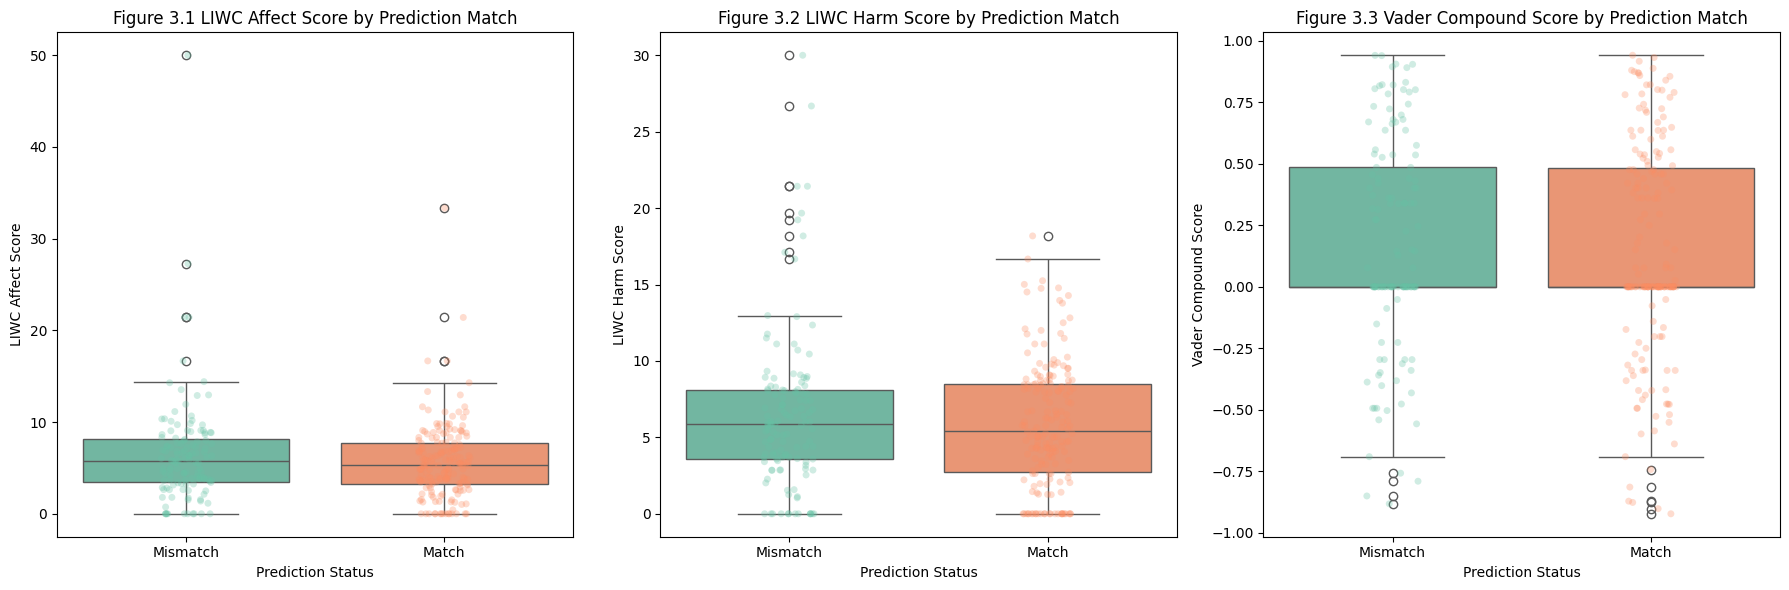

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6)) # Increased figsize for better readability

# Plot 1: liwc_affect
sns.boxplot(data=merged_results_temp, x='prediction_status', y='liwc_affect', hue='prediction_status', palette='Set2', legend=False, ax=ax1)
sns.stripplot(data=merged_results_temp, x='prediction_status', y='liwc_affect', hue='prediction_status', palette='Set2', alpha=0.3, legend=False, ax=ax1)
ax1.set_title('Figure 3.1 LIWC Affect Score by Prediction Match')
ax1.set_xlabel('Prediction Status')
ax1.set_ylabel('LIWC Affect Score')

# Plot 2: liwc_harm
sns.boxplot(data=merged_results_temp, x='prediction_status', y='liwc_harm', hue='prediction_status', palette='Set2', legend=False, ax=ax2)
sns.stripplot(data=merged_results_temp, x='prediction_status', y='liwc_harm', hue='prediction_status', palette='Set2', alpha=0.3, legend=False, ax=ax2)
ax2.set_title('Figure 3.2 LIWC Harm Score by Prediction Match')
ax2.set_xlabel('Prediction Status')
ax2.set_ylabel('LIWC Harm Score')

# Plot 3: vader_compound
sns.boxplot(data=merged_results_temp, x='prediction_status', y='vader_compound', hue='prediction_status', palette='Set2', legend=False, ax=ax3)
sns.stripplot(data=merged_results_temp, x='prediction_status', y='vader_compound', hue='prediction_status', palette='Set2', alpha=0.3, legend=False, ax=ax3)
ax3.set_title('Figure 3.3 Vader Compound Score by Prediction Match')
ax3.set_xlabel('Prediction Status')
ax3.set_ylabel('Vader Compound Score')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

Text(0.5, 1.02, 'Figure 4. Pairplot of Predictor Variables')

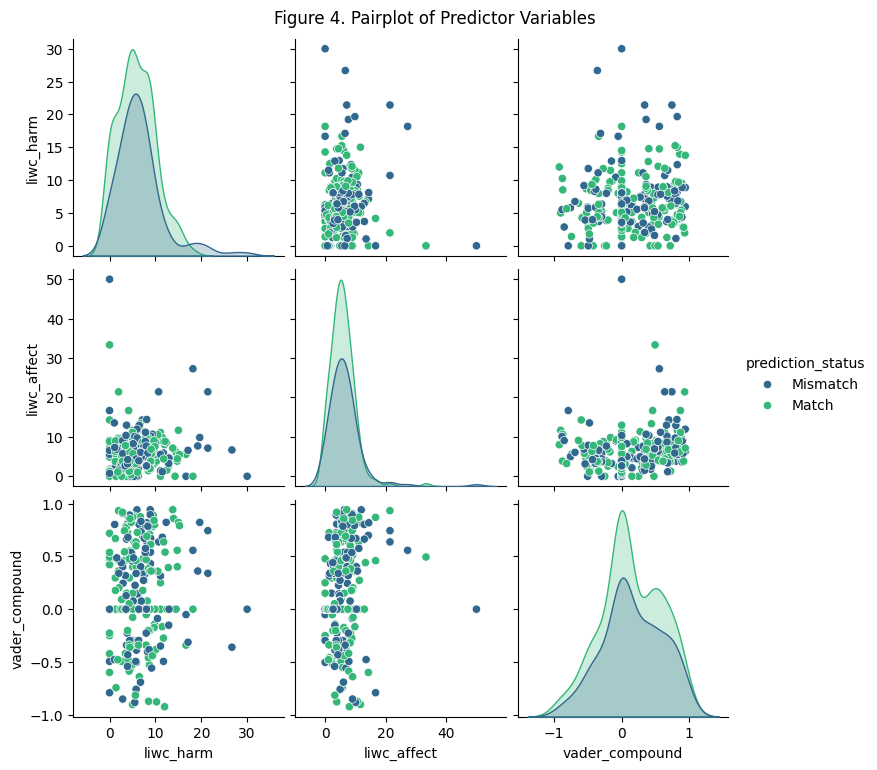

In [20]:
# Plot VADER scores vs LIWC scores
g = sns.pairplot(merged_results_temp, vars=['liwc_harm', 'liwc_affect', 'vader_compound'], hue='prediction_status', palette='viridis')
g.fig.suptitle('Figure 4. Pairplot of Predictor Variables', y=1.02)


### Correlation Heatmap of All LIWC and VADER Scores

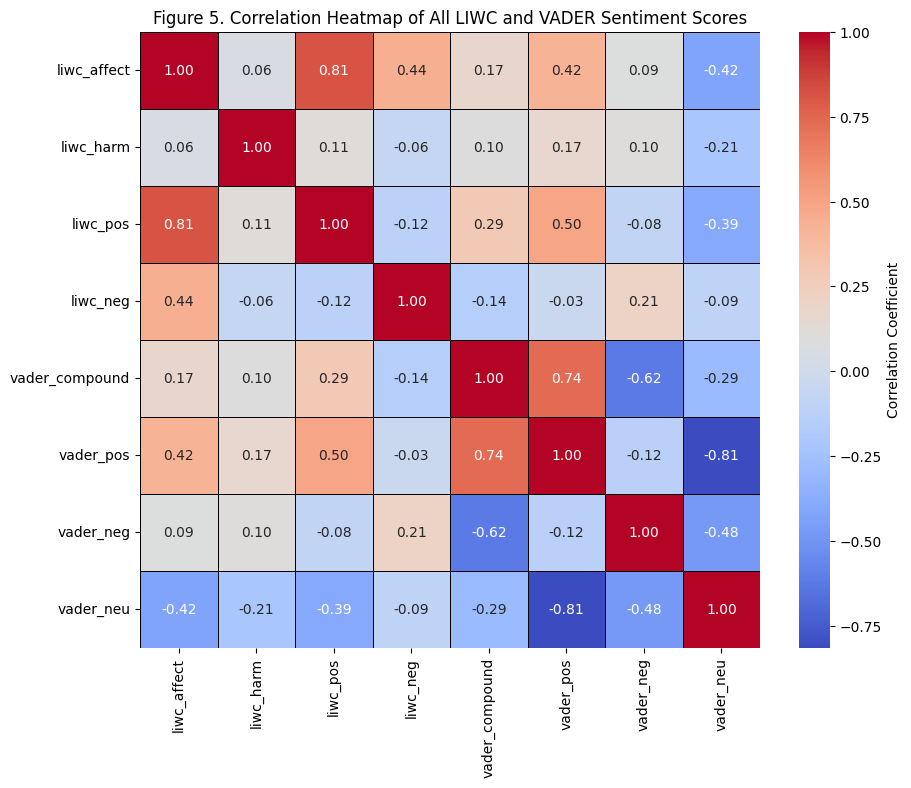

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define all LIWC and VADER sentiment columns
sentiment_cols = [
    'liwc_affect', 'liwc_harm', 'liwc_pos', 'liwc_neg',
    'vader_compound', 'vader_pos', 'vader_neg', 'vader_neu'
]

# Calculate the correlation matrix for these columns
corr_matrix_all = merged_results_temp[sentiment_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix_all,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='black',
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Figure 5. Correlation Heatmap of All LIWC and VADER Sentiment Scores')
plt.show()

In [23]:
from matplotlib.patches import Rectangle

# remove vader_compound, only keep vader_neg

In [24]:
def parse_hashtag_string(s):
    """
    Convert a comma-separated hashtag string into a cleaned set of tags.
    Example input: '#fun, #Music, travel '
    Output: {'fun', 'music', 'travel'}
    """
    if pd.isna(s):
        return set()
    return {
        tag.strip().lstrip('#').lower()
        for tag in s.split(',')
        if tag.strip() != ''
    }

In [25]:
def jaccard_similarity(a, b):
    """
    Compute Jaccard similarity between two sets.
    """
    if not a and not b:
        return 0.0
    inter = a.intersection(b)
    union = a.union(b)
    return len(inter) / len(union) if union else 0.0

In [26]:
# Apply parsing and Jaccard to each row
merged_results_temp['human_tag_set'] = merged_results_temp['human_hashtags'].apply(parse_hashtag_string)
merged_results_temp['llm_tag_set'] = merged_results_temp['llm_hashtags'].apply(parse_hashtag_string)


In [38]:
merged_results_temp['jaccard_sim'] = merged_results_temp.apply(
    lambda row: jaccard_similarity(row['human_tag_set'], row['llm_tag_set']),
    axis=1
)

# Continuous mismatch index: 1 - Jaccard
merged_results_temp['mismatch_index'] = 1 - merged_results_temp['jaccard_sim']

# Binary mismatch (primary outcome): 1 = no overlap, 0 = at least one overlapping hashtag
merged_results_temp['mismatch_binary'] = (merged_results_temp['jaccard_sim'] == 0).astype(int)

In [31]:
merged_results_temp.head(3)

,ID,description,label,pred,Match,hashtag,liwc_harm,liwc_affect,liwc_pos,liwc_neg,...,human_hashtags,llm_hashtags,vader_compound,vader_pos,vader_neu,vader_neg,human_tag_set,llm_tag_set,jaccard_sim,mismatch_index
0,65,New Movie,1,2,False,cigarette,0.0,50.00,50.00,0.0,...,cigarette,vaping,0.0000,0.000,1.000,0.0,{cigarette},{vaping},0.0,1.0
1,1483,Swisher Sweets Commercial,4,4,True,swisher,0.0,33.33,33.33,0.0,...,swisher,swisher,0.4939,0.615,0.385,0.0,{swisher},{swisher},1.0,0.0
2,1327,Hay bales and cat tails.,4,4,True,swisher,0.0,0.00,0.00,0.0,...,swisher,swisher,0.0000,0.000,1.000,0.0,{swisher},{swisher},1.0,0.0


In [37]:

# Overall discriptive analysis
from tabulate import tabulate
sentiment_cols = ['liwc_harm', 'liwc_pos', 'liwc_neg','vader_pos', 'vader_neg', 'vader_neu']
a = pd.DataFrame(merged_results_temp[sentiment_cols].describe())
print("\n          Table 1. Descriptive Statistics for LIWC and VADER Sentiment Features   ")
print(tabulate(a, headers=sentiment_cols, tablefmt="fancy_grid"))


          Table 1. Descriptive Statistics for LIWC and VADER Sentiment Features   
╒═══════╤═════════════╤════════════╤════════════╤═════════════╤═════════════╤═════════════╕
│       │   liwc_harm │   liwc_pos │   liwc_neg │   vader_pos │   vader_neg │   vader_neu │
╞═══════╪═════════════╪════════════╪════════════╪═════════════╪═════════════╪═════════════╡
│ count │   308       │  308       │  308       │ 308         │ 308         │  308        │
├───────┼─────────────┼────────────┼────────────┼─────────────┼─────────────┼─────────────┤
│ mean  │     6.13295 │    2.94377 │    2.92276 │   0.0918312 │   0.042776  │    0.865373 │
├───────┼─────────────┼────────────┼────────────┼─────────────┼─────────────┼─────────────┤
│ std   │     4.56582 │    4.39852 │    2.74753 │   0.112155  │   0.0739056 │    0.126559 │
├───────┼─────────────┼────────────┼────────────┼─────────────┼─────────────┼─────────────┤
│ min   │     0       │    0       │    0       │   0         │   0         │    0.385  

# Model and results



In [35]:
# Simple logistic regression using statsmodels (formula)

formula = "mismatch_binary ~ liwc_harm + liwc_pos + liwc_neg + vader_pos + vader_neu + vader_neg + text_len"
logit_model = smf.logit(formula=formula, data=merged_results_temp).fit(disp=False)

print(logit_model.summary(title='Table 2. Logistic Regression Model: Mismatch Prediction'))

           Table 2. Logistic Regression Model: Mismatch Prediction            
Dep. Variable:        mismatch_binary   No. Observations:                  308
Model:                          Logit   Df Residuals:                      300
Method:                           MLE   Df Model:                            7
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                 0.02917
Time:                        01:11:40   Log-Likelihood:                -203.30
converged:                       True   LL-Null:                       -209.41
Covariance Type:            nonrobust   LLR p-value:                   0.09360
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    702.1297    501.751      1.399      0.162    -281.284    1685.544
liwc_harm      0.0423      0.027      1.569      0.117      -0.011       0.095
liwc_pos      -0.0078      0.035     -0.221      0.8

# Logistic regression diagnos plot

In [50]:
# pull out coefficient
coefs = logit_model.params
conf = logit_model.conf_int()
conf.columns = ["ci_lower", "ci_upper"]
coef_df = pd.concat([coefs, conf], axis=1)
coef_df = coef_df.reset_index().rename(columns={"index": "term", 0: "coef"})

# Drop intercept for plotting
coef_df = coef_df[coef_df["term"] != "Intercept"]


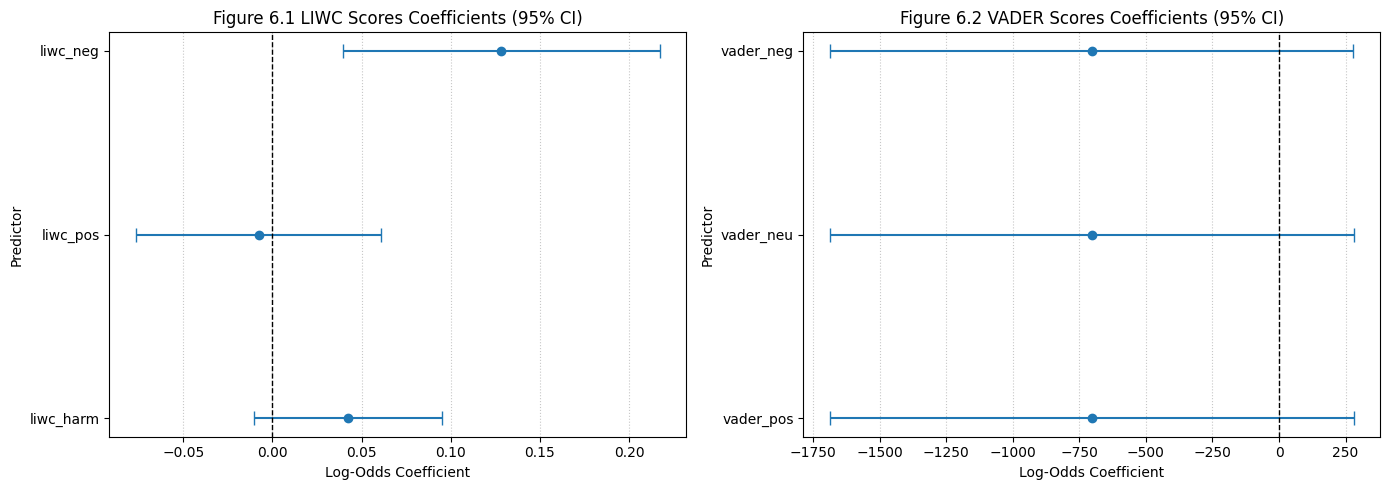

In [51]:

import matplotlib.pyplot as plt
import pandas as pd


liwc_coefficients = [
    'liwc_harm',
    'liwc_pos',
    'liwc_neg'
]
# Filter the coef_df for LIWC coefficients
filtered_liwc_coef_df = coef_df[coef_df['term'].isin(liwc_coefficients)].copy()

# Define the VADER coefficients you want to plot
vader_coefficients = [
    'vader_pos',
    'vader_neu',
    'vader_neg'
]
# Filter the coef_df for VADER coefficients
filtered_vader_coef_df = coef_df[coef_df['term'].isin(vader_coefficients)].copy()

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # Adjust figsize as needed

# Plot 1: LIWC Coefficients
axes[0].errorbar(
    x=filtered_liwc_coef_df["coef"],
    y=filtered_liwc_coef_df["term"],
    xerr=[
        filtered_liwc_coef_df["coef"] - filtered_liwc_coef_df["ci_lower"],
        filtered_liwc_coef_df["ci_upper"] - filtered_liwc_coef_df["coef"],
    ],
    fmt="o",
    capsize=5
)
axes[0].axvline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_xlabel("Log-Odds Coefficient")
axes[0].set_ylabel("Predictor")
axes[0].set_title("Figure 6.1 LIWC Scores Coefficients (95% CI)")
axes[0].grid(axis='x', linestyle=':', alpha=0.7)

# Plot 2: VADER Coefficients
axes[1].errorbar(
    x=filtered_vader_coef_df["coef"],
    y=filtered_vader_coef_df["term"],
    xerr=[
        filtered_vader_coef_df["coef"] - filtered_vader_coef_df["ci_lower"],
        filtered_vader_coef_df["ci_upper"] - filtered_vader_coef_df["coef"],
    ],
    fmt="o",
    capsize=5
)
axes[1].axvline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_xlabel("Log-Odds Coefficient")
axes[1].set_ylabel("Predictor")
axes[1].set_title("Figure 6.2 VADER Scores Coefficients (95% CI)")
axes[1].grid(axis='x', linestyle=':', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [39]:


def predict_mismatch_prob(vader_vals=None, harm_vals=None, affect_vals=None):
    """
    Generate a DataFrame of predictions for given vectors of vader_compound / liwc_harm / liwc_affect.
    Holds other predictors at their mean if not provided.
    """
    mean_vader = merged_results_temp["vader_compound"].mean()
    mean_harm = merged_results_temp["liwc_harm"].mean()
    mean_affect = merged_results_temp["liwc_affect"].mean()

    # If a vector is provided, use that; otherwise use mean
    if vader_vals is None:
        vader_vals = np.array([mean_vader])
    if harm_vals is None:
        harm_vals = np.array([mean_harm])
    if affect_vals is None:
        affect_vals = np.array([mean_affect])

    # Broadcast to same shape (for 1D convenience)
    max_len = max(len(vader_vals), len(harm_vals), len(affect_vals))

    vader_vals = np.resize(vader_vals, max_len)
    harm_vals = np.resize(harm_vals, max_len)
    affect_vals = np.resize(affect_vals, max_len)

    grid = pd.DataFrame(
        {
            "vader_compound": vader_vals,
            "liwc_harm": harm_vals,
            "liwc_affect": affect_vals,
        }
    )

    grid["pred_prob"] = logit_model.predict(grid)
    return grid




(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

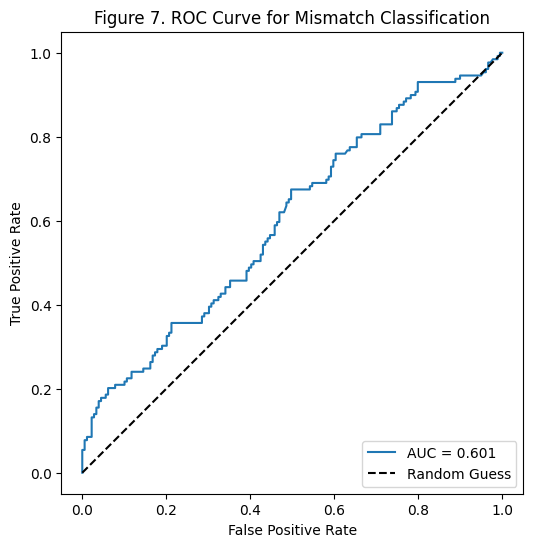

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC Curve for Logistic Model
y_true = merged_results_temp["mismatch_binary"].values
y_pred = logit_model.predict(merged_results_temp)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Figure 7. ROC Curve for Mismatch Classification")
plt.legend(loc="lower right")
plt.axis("square")

All 15 figures generated.


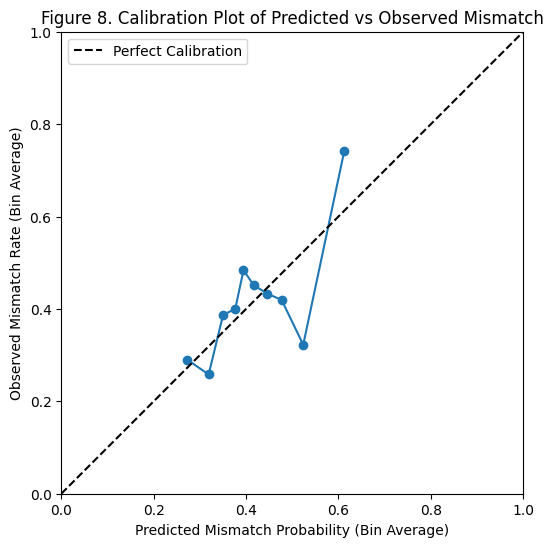

In [41]:

# Calibration Plot (Observed vs Predicted)
df_cal = merged_results_temp.copy()
df_cal["pred_prob"] = y_pred
df_cal["prob_bin"] = pd.qcut(df_cal["pred_prob"], 10, labels=False)

calib = (
    df_cal.groupby("prob_bin")
    .agg(
        mean_pred=("pred_prob", "mean"),
        mean_obs=("mismatch_binary", "mean"),
        n=("mismatch_binary", "size"),
    )
    .reset_index(drop=True)
)

plt.figure(figsize=(6, 6))
plt.plot(calib["mean_pred"], calib["mean_obs"], "o-")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Predicted Mismatch Probability (Bin Average)")
plt.ylabel("Observed Mismatch Rate (Bin Average)")
plt.title("Figure 8. Calibration Plot of Predicted vs Observed Mismatch")
plt.legend()
plt.axis("square")
plt.xlim(0, 1)
plt.ylim(0, 1)

print("All 15 figures generated.")